<a href="https://colab.research.google.com/github/dlfelps/ml_portfolio/blob/main/concept_bottleneck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides an example of an explainable AI technique called [Concept Bottleneck Models](https://arxiv.org/abs/2007.04612).

It has a companion [blog post](https://dlfelps.github.io/2024/06/03/few-shot.html).

It is part of Daniel Felps' [ML portfolio](https://github.com/dlfelps/ml_portfolio/tree/main)

# SETUP ENVIRONMENT

In [1]:
!git clone https://github.com/dlfelps/datasets.git
!git clone https://github.com/dlfelps/concept_bottleneck.git
!pip install pytorchcv

Cloning into 'datasets'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 21 (delta 6), reused 18 (delta 6), pack-reused 0
Receiving objects: 100% (21/21), 6.59 KiB | 3.29 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Cloning into 'concept_bottleneck'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 42 (delta 15), reused 34 (delta 10), pack-reused 0
Receiving objects: 100% (42/42), 9.24 MiB | 5.00 MiB/s, done.
Resolving deltas: 100% (15/15), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 2.2 MB/s eta 0:00:00


# IMPORTS

In [22]:
from pathlib import Path
import pickle
import numpy as np
import re
import pandas as pd
import os

import matplotlib.pyplot as plt

from pytorchcv.model_provider import get_model

from datasets.CUB200 import CUB200, CUB200_attributes, recombine_attributes
from concept_bottleneck.cav import CAV
from concept_bottleneck.interpretablePredictor import InterpretablePredictor
from concept_bottleneck.conceptBottleneck import ConceptBottleneck
from concept_bottleneck.utils import predict_embeddings

import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score

# DOWNLOAD DATASET (CUB)

In [3]:
# TODO add transforms back
cub = CUB200('.', download=True, is_test=False, transform = v2.Compose([
      v2.Resize((224,224)),
      v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
      v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))



100%|██████████| 1150585339/1150585339 [01:45<00:00, 10858865.00it/s]


Extracting ./CUB_200_2011.tgz to .


# COMPUTE VECTOR EMBEDDINGS

In [4]:
cub_dataloader = DataLoader(cub, batch_size=100)
cub_res = get_model('resnet18_cub', pretrained=True, root='.')
cub_res.output = torch.nn.Identity()
cub_res = cub_res.to('cuda')
cub_embeddings, ids = predict_embeddings(cub_dataloader, cub_res, device='cuda')
id_map = cub.get_id_class_mapper()
classes = np.array(list(map(lambda x: id_map[x], ids)))

Predicting embeddings: 100%|██████████| 58/58 [00:43<00:00,  1.33batch/s]


# CONCEPT BOTTLENECK MODEL

In [5]:
# download pretrained models
!wget https://github.com/dlfelps/ml_portfolio/raw/main/pretrained_models/cav.pkl
!wget https://github.com/dlfelps/ml_portfolio/raw/main/pretrained_models/ip.pkl

--2024-05-27 10:50:21--  https://github.com/dlfelps/ml_portfolio/raw/main/pretrained_models/cav.pkl
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dlfelps/ml_portfolio/main/pretrained_models/cav.pkl [following]
--2024-05-27 10:50:22--  https://raw.githubusercontent.com/dlfelps/ml_portfolio/main/pretrained_models/cav.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7899855 (7.5M) [application/octet-stream]
Saving to: ‘cav.pkl’

cav.pkl             100%[===================>]   7.53M  --.-KB/s    in 0.03s   

2024-05-27 10:50:22 (258 MB/s) - ‘cav.pkl’ saved [7899855/7899855]

--2024-05-27 10:50

In [6]:
cbm = ConceptBottleneck()
# cbm.fit(cub_embeddings, attributes, classes) # disable comment to train
cbm.load_concept_predictors('cav.pkl') # load pretrained
cbm.load_interpretable_predictor('ip.pkl') # load pretrained


# CLASS ACCURACY

In [7]:
cub_test = CUB200('.', download=True, is_test=True, transform = v2.Compose([
      v2.Resize((224,224)),
      v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
      v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

Files already downloaded and verified


In [8]:
cub_dataloader = DataLoader(cub_test, batch_size=100)
cub_embeddings, ids = predict_embeddings(cub_dataloader, cub_res, device='cuda')
id_map = cub.get_id_class_mapper()
classes = np.array(list(map(lambda x: id_map[x], ids)))

Predicting embeddings: 100%|██████████| 60/60 [00:42<00:00,  1.40batch/s]


In [9]:
preds = cbm.predict(cub_embeddings)


In [10]:
accuracy_score(classes, preds)

0.5944277610944277

# CONCEPT ACCURACY

In [11]:
cub_attr = CUB200_attributes('.', X=cub_embeddings, ids = ids, download=False)
_,attributes = cub_attr.get_xy()

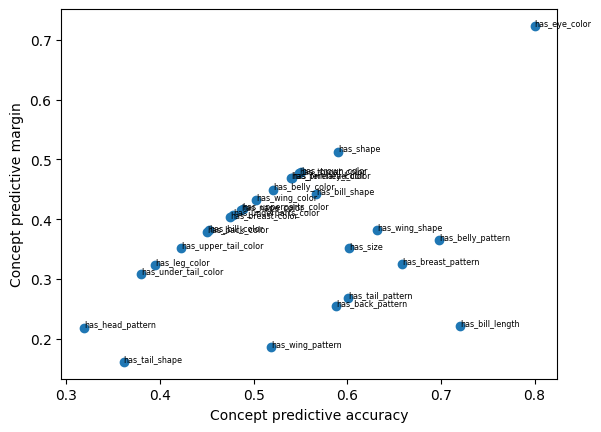

In [26]:
cav = CAV()
cav.load_concept_predictors('cav.pkl')
preds = cav.predict(cub_embeddings)
concept_accuracy = []
base_accuracy = []
for i in range(preds.shape[1]):
  concept_accuracy.append(accuracy_score(attributes[:,i], preds[:,i]))
  base_accuracy.append(1/(np.max(attributes[:,i])))

margin = np.array(concept_accuracy)-np.array(base_accuracy)

_,names = recombine_attributes()
fig, ax = plt.subplots()
ax.scatter(concept_accuracy, margin)

for i, txt in enumerate(names):
    ax.annotate(txt, (concept_accuracy[i], margin[i]), fontsize='xx-small')

ax.set_xlabel('Concept predictive accuracy')
ax.set_ylabel('Concept predictive margin')

fig.savefig('concepts.png')


